# Network topology evaluation of adjacencies calculated from expression data
**Authorship:** Adam Klie (last updated: 08/09/2023)<br>
***
**Description:** This notebook takes in any adjacencies calculated on the Parse sequencing of the `igvf_b01_LeftCortex` dataset and uses CellOracle functions to evaluate the network topology of the adjacencies. 
***

In [ ]:
%matplotlib inline

# Set-up

In [2]:
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

In [3]:
# CellOracle
import celloracle as co
from igraph import Graph
co.__version__

/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/cellar/users/aklie/opt/miniconda3/envs/celloracle/lib/python3.8/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(

'0.14.0'

In [114]:
from celloracle.network_analysis.links_object import _thresholding
from sklearn.linear_model import LinearRegression as lr

def read_links_dict_from_metadata(metadata_df, verbose=True):
    links_dict = {}
    for _, row in metadata_df.iterrows():
        name = f"{row['method']}_{row['cells']}_{row['genotype']}_{row['genes']}_{row['normalization']}"
        links_file = row["output_table_path"]
        links_df = pd.read_csv(links_file, sep="\t")
        links_dict[name] = links_df
        if verbose:
            print(f"Finished reading {name} that has {len(links_df)} links")
    return links_dict

def filter_links_dict(links_dict, p=None, weight="weight_unsigned", threshold_number=2000, verbose=True):
    filtered_links_dict = {}
    for name, links_df in links_dict.items():
        filtered_links_df = _thresholding(links_df, p=p, weight=weight, threshold_number=threshold_number)
        if verbose:
            print(f"{name} went from {len(links_df)} to {len(filtered_links_df)}")
        filtered_links_dict[name] = filtered_links_df
    return filtered_links_dict

def create_igraph_from_links(links):
    g = Graph.DataFrame(links[["source", "target"]], directed=True, use_vids=False)
    g.es["weight"] = links["weight_minmax_normalized"].values.copy()
    return g

def scale_free_topology_score(g):
    degree_df = pd.DataFrame(g.degree(mode="all"), columns=["degree"])
    dist = degree_df.degree.value_counts()/degree_df.degree.value_counts().sum()
    dist.index = dist.index.astype(int)
    x = np.log(dist.index.values).reshape([-1,1])
    y = np.log(dist.values).reshape([-1,1])
    model = lr()
    model.fit(x,y)
    return model.score(x,y)

def mean_connectivity(g):
    return np.mean(g.degree(mode="all"))

def median_connectivity(g):
    return np.median(g.degree(mode="all"))

def max_connectivity(g):
    return np.max(g.degree(mode="all"))

def network_scores(g):
    return pd.Series({
        "scale_free_topology_score": scale_free_topology_score(g),
        "mean_connectivity": mean_connectivity(g),
        "median_connectivity": median_connectivity(g),
        "max_connectivity": max_connectivity(g)
    })

def network_scores_from_links_dict(links_dict, verbose=True):
    network_scores_df = pd.DataFrame()
    for name, links in links_dict.items():
        g = create_igraph_from_links(links)
        network_scores_df[name] = network_scores(g)
        if verbose:
            print(f"Finished calculating network scores for {name}")
    return network_scores_df

# Load metadata file

In [110]:
# Read in all the networks
metadata_df = pd.read_csv("/cellar/users/aklie/projects/igvf/topic_grn_links/eval/metadata/igvf_b01_LeftCortex/01Sep23/eval_metadata.tsv", sep="\t")
len(metadata_df)

48

In [111]:
# Read in all the links
links_dict = read_links_dict_from_metadata(metadata_df, verbose=False)

In [112]:
# Threshold the links
filtered_links_dict = filter_links_dict(links_dict, p=None, weight="weight_unsigned", threshold_number=2000, verbose=False)

In [115]:
# Calculate network scores
network_scores_df = network_scores_from_links_dict(filtered_links_dict, verbose=True)

Finished calculating network scores for aracne_balanced_genotype_microglia_B6J_0.05_raw
Finished calculating network scores for aracne_balanced_genotype_microglia_CASTJ_0.05_raw
Finished calculating network scores for aracne_balanced_genotype_microglia_both_0.05_raw
Finished calculating network scores for aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k
Finished calculating network scores for aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k
Finished calculating network scores for aracne_balanced_genotype_microglia_both_0.05_log1p_cp10k
Finished calculating network scores for aracne_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf
Finished calculating network scores for aracne_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf
Finished calculating network scores for aracne_balanced_genotype_microglia_both_0.05_pf_log1p_pf
Finished calculating network scores for aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank
Finished calculating network scores for aracne_balanced_ge

In [116]:
# Cluster this dataframe by columns
network_scores_df = network_scores_df.T

,aracne_balanced_genotype_microglia_B6J_0.05_raw,aracne_balanced_genotype_microglia_CASTJ_0.05_raw,aracne_balanced_genotype_microglia_both_0.05_raw,aracne_balanced_genotype_microglia_B6J_0.05_log1p_cp10k,aracne_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k,aracne_balanced_genotype_microglia_both_0.05_log1p_cp10k,aracne_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,aracne_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,aracne_balanced_genotype_microglia_both_0.05_pf_log1p_pf,aracne_balanced_genotype_microglia_B6J_0.05_cpm_rank,...,wgcna_balanced_genotype_microglia_both_0.05_raw,wgcna_balanced_genotype_microglia_B6J_0.05_log1p_cp10k,wgcna_balanced_genotype_microglia_CASTJ_0.05_log1p_cp10k,wgcna_balanced_genotype_microglia_both_0.05_log1p_cp10k,wgcna_balanced_genotype_microglia_B6J_0.05_pf_log1p_pf,wgcna_balanced_genotype_microglia_CASTJ_0.05_pf_log1p_pf,wgcna_balanced_genotype_microglia_both_0.05_pf_log1p_pf,wgcna_balanced_genotype_microglia_B6J_0.05_cpm_rank,wgcna_balanced_genotype_microglia_CASTJ_0.05_cpm_rank,wgcna_balanced_genotype_microglia_both_0.05_cpm_rank
scale_free_topology_score,0.891825,0.927171,0.884671,0.853247,0.813415,0.765676,0.832662,0.80045,0.735181,0.887361,...,0.709320,0.769896,0.745140,0.735256,0.779899,0.800121,0.679293,0.894845,0.848115,0.777090
mean_connectivity,1.569859,1.399022,1.626678,1.685630,1.702128,1.727862,1.697073,1.70503,1.745962,1.483129,...,5.780347,4.872107,3.364172,4.347826,3.046458,2.745367,3.358522,2.484472,2.551020,3.016591
median_connectivity,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,1.000000,1.000000,1.000000
max_connectivity,35.000000,39.000000,43.000000,19.000000,20.000000,21.000000,19.000000,22.00000,22.000000,52.000000,...,271.000000,255.000000,196.000000,259.000000,203.000000,151.000000,230.000000,29.000000,52.000000,192.000000


# Scratch

In [85]:
# Calculate the mean connectivty of the network
mean_connectivity = df["degree_all"].mean()
max_connectivity = df["degree_all"].max()
median_connectivity = df["degree_all"].median()
print(f"mean connectivity: {mean_connectivity}")
print(f"max connectivity: {max_connectivity}")
print(f"median connectivity: {median_connectivity}")

mean connectivity: 2.7453671928620453
max connectivity: 99
median connectivity: 2.0


In [86]:
df.sort_values("degree_all", ascending=False).head(10)

,name,degree_all,degree_centrality_all,degree_in,degree_centrality_in,degree_out,degree_centrality_out,betweenness_centrality,eigenvector_centrality
vertex ID,,,,,,,,,
1,Gm28187,99,0.067995,99,0.067995,0,0.000000,0.0,1.000000
16,Rbpj,46,0.031593,1,0.000687,45,0.030907,230.0,0.006942
44,Trps1,28,0.019231,3,0.002060,25,0.017170,282.0,0.052923
336,Zfp710,16,0.010989,0,0.000000,16,0.010989,0.0,0.000891
6,E230016K23Rik,15,0.010302,15,0.010302,0,0.000000,0.0,0.003384
368,Rora,14,0.009615,1,0.000687,13,0.008929,78.0,0.024860
36,Gabpb1,12,0.008242,0,0.000000,12,0.008242,0.0,0.098346
71,Ensa,12,0.008242,12,0.008242,0,0.000000,0.0,0.002697
29,Cnot6,12,0.008242,3,0.002060,9,0.006181,61.0,0.104345


In [87]:
from celloracle.network_analysis.network_structure_analysis import linkList_to_networkgraph, _get_degree_info_from_NG

In [78]:
g = linkList_to_networkgraph(test)
degree_df = _get_degree_info_from_NG(g)

In [79]:
df = degree_df.copy()



In [80]:
df.sort_values("degree", ascending=False).head(10)

,degree
ind,
Gm28187,99
Erf,9
Ugp2,9
Ski,9
Ncoa2,9
Hmbox1,9
Sf1,9
Zfp384,9
Mlxipl,9


Text(0, 0.5, 'log P(k)')

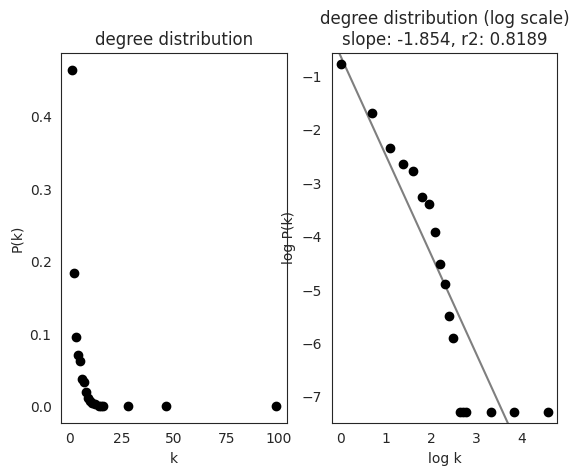

In [66]:
fig, ax = plt.subplots(1,2)

ax[0].scatter(dist.index.values, dist.values, c="black")
ax[0].set_title("degree distribution")
ax[0].set_xlabel("k")
ax[0].set_ylabel("P(k)")



ax[1].set_title(f"degree distribution (log scale)\nslope: {model.coef_[0][0] :.4g}, r2: { :.4g}")
ax[1].plot(x_.flatten(), y_.flatten(), c="black", alpha=0.5)

ax[1].scatter(x.flatten(), y.flatten(), c="black")
ax[1].set_ylim([y.min()-0.2, y.max()+0.2])
ax[1].set_xlim([-0.2, x.max()+0.2])
ax[1].set_xlabel("log k")
ax[1].set_ylabel("log P(k)")